# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [2]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm


### 데이터 읽어오기


In [3]:
ROOT_DIR = "./data/"
RANDOM_STATE = 110

# Load data
df = pd.read_csv(os.path.join(ROOT_DIR, "train_cleaned.csv"))
df

,Equipment_Dam,Model.Suffix,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,240.0,2.5,-90,100,1030,16,14.9,8.4,...,156.0,427.9,428.0,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #2,AJX75334501,1000.0,12.5,90,85,280,16,14.7,8.5,...,694.0,1324.2,1324.2,243.5,114.612,19.8,10.0,73,1,Normal
2,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,16,13.2,6.5,...,156.0,427.9,428.0,243.7,85.000,19.7,8.0,483,1,Normal
3,Dam dispenser #2,AJX75334501,1000.0,12.5,90,70,280,16,13.2,7.6,...,694.0,1324.2,1324.2,243.5,85.000,19.9,11.0,105,1,Normal
4,Dam dispenser #2,AJX75334501,1000.0,12.5,90,85,280,16,14.7,8.5,...,694.0,1324.2,1324.2,243.5,114.612,20.0,15.0,78,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,9.7,4.9,...,156.0,427.9,428.0,243.7,85.000,19.6,2.0,56,1,Normal
40502,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,9.7,4.9,...,156.0,427.9,428.0,243.7,85.000,19.3,8.0,329,1,Normal
40503,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,17.0,5.0,...,156.0,427.9,428.0,243.7,85.000,19.2,1.0,318,1,Normal
40504,Dam dispenser #2,AJX75334501,1000.0,12.5,90,70,280,10,9.7,4.9,...,694.0,1324.2,1324.2,243.5,85.000,20.1,13.0,117,1,Normal


(array([ 2924.,  6925.,  5919.,  6008.,   592., 10598.,  2929.,   352.,
         1010.,  3249.]),
 array([708.5, 709.5, 710.5, 711.5, 712.5, 713.5, 714.5, 715.5, 716.5,
        717.5, 718.5]),
 <BarContainer object of 10 artists>)

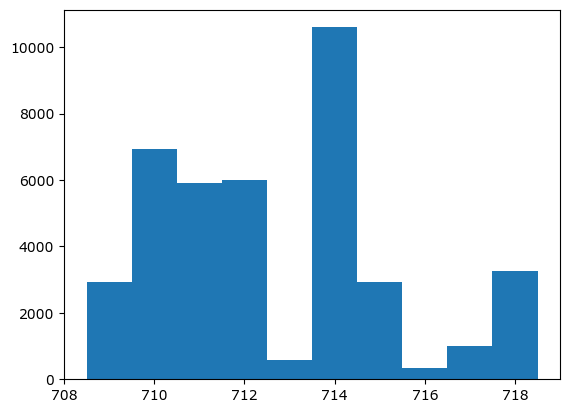

In [6]:
sumx=df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam"]+df["HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam"]
plt.hist(sumx)

(array([8.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0419e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 614.8 ,  689.56,  764.32,  839.08,  913.84,  988.6 , 1063.36,
        1138.12, 1212.88, 1287.64, 1362.4 ]),
 <BarContainer object of 10 artists>)

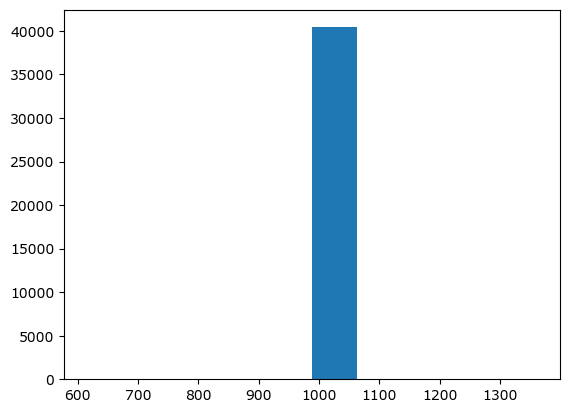

In [7]:
sumx=df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1"]+df["HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1"]
plt.hist(sumx)

방출 속력과 시간을 통해 부피 계산
$$
v=\frac{\Delta x}{\Delta t}\\
V=A\times \Delta x,\quad \Delta x=v\Delta t\\
V=A\times vt
$$

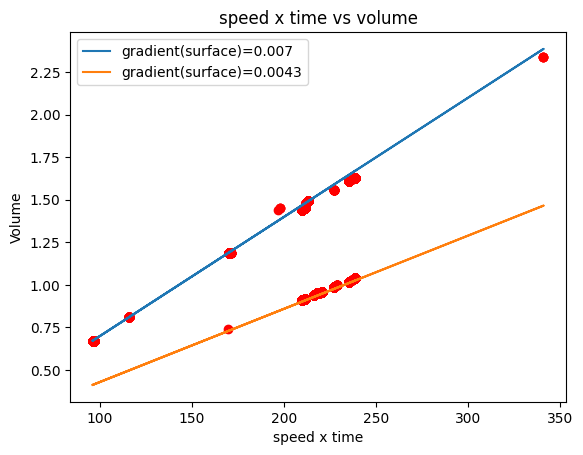

In [4]:
import matplotlib.pyplot as plt

speed = df["DISCHARGED SPEED OF RESIN Collect Result_Dam"]

x = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"]
y = df["Dispense Volume(Stage1) Collect Result_Dam"]

color = df['target']
plt.title("speed x time vs volume")
plt.plot(speed*x,y,'ro')
plt.plot(speed*x,0.007*speed*x,label="gradient(surface)=0.007")
plt.plot(speed*x,0.0043*speed*x,label="gradient(surface)=0.0043")
plt.xlabel("speed x time")
plt.ylabel("Volume")
plt.legend(loc='best')

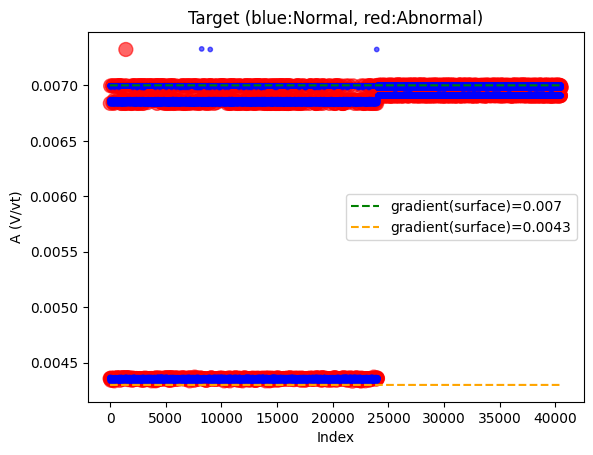

In [7]:

# 색상 및 크기 맵핑 설정
color_map = {'Normal': 'blue', 'AbNormal': 'red'}
size_map = {'Normal': 10, 'AbNormal': 100}  # 'Normal'은 작은 점, 'AbNormal'은 큰 점

# target 값을 색상과 크기로 매핑
df['color'] = df['target'].map(color_map)
df['size'] = df['target'].map(size_map)

# 필요한 값 계산
V = df["Dispense Volume(Stage1) Collect Result_Dam"]
v = df["DISCHARGED SPEED OF RESIN Collect Result_Dam"]
t = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"]

# y축 값 계산 (A = V / (v * t))
df['A'] = V / (v * t)

# 데이터프레임을 크기에 따라 정렬 (큰 점 먼저)
df_sorted = df.sort_values(by='size', ascending=False)

# 플로팅
plt.title("Target (blue:Normal, red:Abnormal)")
plt.scatter(df_sorted.index, df_sorted['A'], c=df_sorted['color'], s=df_sorted['size'], alpha=0.6)

# 추가 라인 그리기 - 각 점에서의 일정한 y값을 생성하기 위해 x_index의 길이와 동일한 배열 생성
plt.plot(df.index, [0.007]*len(df), label="gradient(surface)=0.007", linestyle='--', color='green')
plt.plot(df.index, [0.0043]*len(df), label="gradient(surface)=0.0043", linestyle='--', color='orange')

plt.xlabel("Index")
plt.ylabel("A (V/vt)")
plt.legend(loc='best')
plt.show()


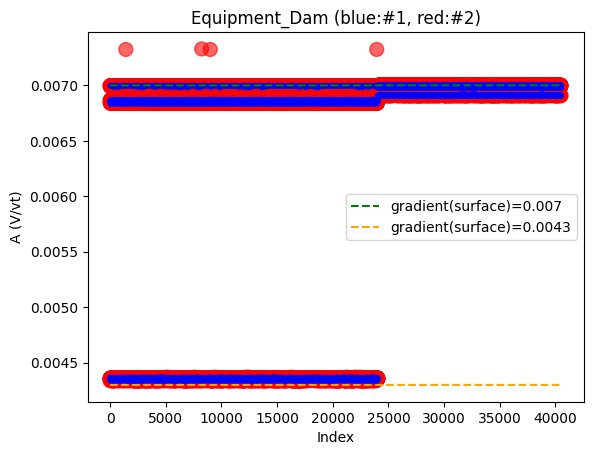

In [10]:

# 색상 및 크기 맵핑 설정
color_map = {'Dam dispenser #1': 'blue', 'Dam dispenser #2': 'red'}
size_map = {'Dam dispenser #1': 10, 'Dam dispenser #2': 100}  # '#1'은 작은 점, '#2'은 큰 점

# target 값을 색상과 크기로 매핑
df['color'] = df['Equipment_Dam'].map(color_map)
df['size'] = df['Equipment_Dam'].map(size_map)

# 필요한 값 계산
V = df["Dispense Volume(Stage1) Collect Result_Dam"]
v = df["DISCHARGED SPEED OF RESIN Collect Result_Dam"]
t = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"]

# y축 값 계산 (A = V / (v * t))
df['A'] = V / (v * t)

# 데이터프레임을 크기에 따라 정렬 (큰 점 먼저)
df_sorted = df.sort_values(by='size', ascending=False)

# 플로팅
plt.title("Equipment_Dam (blue:#1, red:#2)")
plt.scatter(df_sorted.index, df_sorted['A'], c=df_sorted['color'], s=df_sorted['size'], alpha=0.6)

# 추가 라인 그리기 - 각 점에서의 일정한 y값을 생성하기 위해 x_index의 길이와 동일한 배열 생성
plt.plot(df.index, [0.007]*len(df), label="gradient(surface)=0.007", linestyle='--', color='green')
plt.plot(df.index, [0.0043]*len(df), label="gradient(surface)=0.0043", linestyle='--', color='orange')

plt.xlabel("Index")
plt.ylabel("A (V/vt)")
plt.legend(loc='best')
plt.show()
